In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/Work Project/Flower Recognition/flower_photoss"


In [ ]:
import os

print(os.listdir(data_dir))


['LICENSE.txt', 'roses', 'daisy', 'tulips', 'dandelion', 'sunflowers']


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [ ]:
# Configuration
# -----------------------------
DATASET_DIR = "flower_photos"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
SEED = 123

In [ ]:
# Load Dataset
# -----------------------------
img_height = 224
img_width = 224
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)




Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
# performance optimization

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
# data augmentation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [ ]:
# CNN model

num_classes = len(class_names)

model = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # freeze pretrained weights


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),

(<Lambda name=lambda, built=False>,)

In [ ]:
model = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),

    base_model,

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 932s 3s/step - accuracy: 0.3754 - loss: 1.5140 - val_accuracy: 0.7657 - val_loss: 0.7827
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.6823 - loss: 0.8475 - val_accuracy: 0.8174 - val_loss: 0.5799
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.7680 - loss: 0.6303 - val_accuracy: 0.8488 - val_loss: 0.4909
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.8247 - loss: 0.5048 - val_accuracy: 0.8638 - val_loss: 0.4287
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.8221 - loss: 0.4971 - val_accuracy: 0.8733 - val_loss: 0.3984
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.8419 - loss: 0.4567 - val_accuracy: 0.8828 - val_loss: 0.3775
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.8520 - loss: 0.3903 - val_accuracy: 0.8815 - val_loss: 0.3608
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.8568 - loss: 0.4020 - val_accuracy: 0.8828 - v

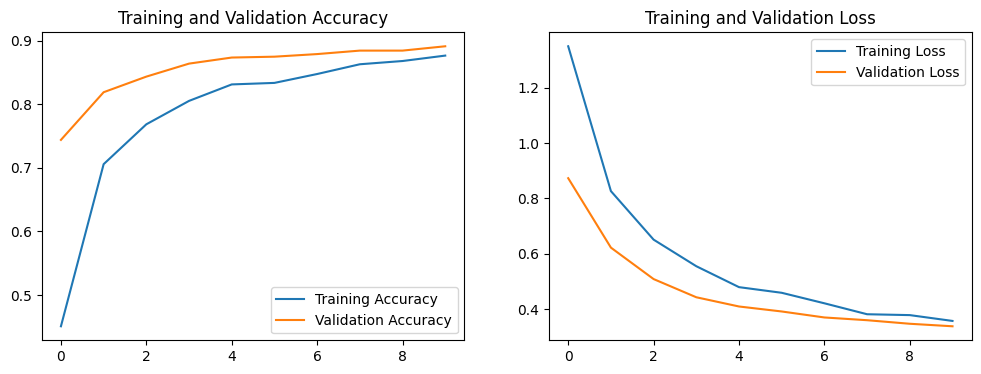

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()